In [ ]:
cd /content/drive/MyDrive/Hybrid

/content/drive/MyDrive/Hybrid


In [ ]:
!pip install cryptography
!pip install pycryptodome


In [ ]:
# Block 1: Loading Dataset
import os
from tqdm.notebook import tqdm

# Path to your images
dataset_path = "/content/drive/MyDrive/Hybrid/images"
output_encrypted_path = "/content/drive/MyDrive/Hybrid/encrypted"
output_decrypted_path = "/content/drive/MyDrive/Hybrid/decrypted"

# Ensure output directories exist
os.makedirs(output_encrypted_path, exist_ok=True)
os.makedirs(output_decrypted_path, exist_ok=True)

# Collect all image paths
image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Found {len(image_files)} image(s) in the dataset.")


Found 5022 image(s) in the dataset.


In [ ]:
# Block 2: Key Generation
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives.hashes import SHA256
import os
import base64

# Generate AES 256-bit key and 3DES key
aes_key = os.urandom(32)  # AES key
des_key = os.urandom(24)  # 3DES key

# Save keys securely
keys_path = "/content/drive/MyDrive/Hybrid/keys"
os.makedirs(keys_path, exist_ok=True)

# Save keys to files
with open(os.path.join(keys_path, "aes_key.key"), "wb") as f:
    f.write(aes_key)

with open(os.path.join(keys_path, "des_key.key"), "wb") as f:
    f.write(des_key)

print("Keys generated and saved.")


Keys generated and saved.


In [ ]:
# Block 3: Hybrid Encryption
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from Crypto.Cipher import DES3
from tqdm.notebook import tqdm

def aes_ctr_encrypt(key, plaintext):
    iv = os.urandom(16)  # Initialization vector
    cipher = Cipher(algorithms.AES(key), modes.CTR(iv))
    encryptor = cipher.encryptor()
    ciphertext = encryptor.update(plaintext) + encryptor.finalize()
    return iv + ciphertext

def des_encrypt(key, plaintext):
    cipher = DES3.new(key, DES3.MODE_ECB)
    return cipher.encrypt(plaintext)

# Encrypt images
for image_path in tqdm(image_files, desc="Encrypting Images"):
    with open(image_path, "rb") as f:
        image_data = f.read()

    # Encrypt with AES
    aes_encrypted = aes_ctr_encrypt(aes_key, image_data)

    # Encrypt AES output with 3DES
    aes_encrypted_padded = aes_encrypted + b"\0" * ((8 - len(aes_encrypted) % 8) % 8)  # Pad for 3DES
    hybrid_encrypted = des_encrypt(des_key, aes_encrypted_padded)

    # Save encrypted file
    encrypted_filename = os.path.join(output_encrypted_path, os.path.basename(image_path) + ".enc")
    with open(encrypted_filename, "wb") as f:
        f.write(hybrid_encrypted)

print("Encryption completed. Encrypted files saved in:", output_encrypted_path)


Encrypting Images:   0%|          | 0/5022 [00:00<?, ?it/s]

Encryption completed. Encrypted files saved in: /content/drive/MyDrive/Hybrid/encrypted


In [ ]:
# Block 4: Hybrid Decryption
from Crypto.Cipher import DES3

def aes_ctr_decrypt(key, ciphertext):
    iv = ciphertext[:16]  # Extract IV
    actual_ciphertext = ciphertext[16:]
    cipher = Cipher(algorithms.AES(key), modes.CTR(iv))
    decryptor = cipher.decryptor()
    plaintext = decryptor.update(actual_ciphertext) + decryptor.finalize()
    return plaintext

def des_decrypt(key, ciphertext):
    cipher = DES3.new(key, DES3.MODE_ECB)
    return cipher.decrypt(ciphertext)

# Decrypt images
for encrypted_file in tqdm(os.listdir(output_encrypted_path), desc="Decrypting Images"):
    encrypted_path = os.path.join(output_encrypted_path, encrypted_file)
    with open(encrypted_path, "rb") as f:
        hybrid_encrypted = f.read()

    # Decrypt with 3DES
    aes_encrypted_padded = des_decrypt(des_key, hybrid_encrypted)

    # Remove padding
    aes_encrypted = aes_encrypted_padded.rstrip(b"\0")

    # Decrypt with AES
    decrypted_data = aes_ctr_decrypt(aes_key, aes_encrypted)

    # Save decrypted file
    decrypted_filename = os.path.join(output_decrypted_path, encrypted_file.replace(".enc", ""))
    with open(decrypted_filename, "wb") as f:
        f.write(decrypted_data)

print("Decryption completed. Decrypted files saved in:", output_decrypted_path)


Decrypting Images:   0%|          | 0/5022 [00:00<?, ?it/s]

Decryption completed. Decrypted files saved in: /content/drive/MyDrive/Hybrid/decrypted


In [ ]:
# Block 5: File Size Statistics
original_sizes = []
encrypted_sizes = []
decrypted_sizes = []

# Compare sizes
for image_path in image_files:
    original_sizes.append(os.path.getsize(image_path))
    encrypted_path = os.path.join(output_encrypted_path, os.path.basename(image_path) + ".enc")
    encrypted_sizes.append(os.path.getsize(encrypted_path))
    decrypted_path = os.path.join(output_decrypted_path, os.path.basename(image_path))
    decrypted_sizes.append(os.path.getsize(decrypted_path))

print("File Size Statistics:")
for i, image_path in enumerate(image_files):
    print(f"File: {os.path.basename(image_path)}")
    print(f"  Original Size: {original_sizes[i]} bytes")
    print(f"  Encrypted Size: {encrypted_sizes[i]} bytes")
    print(f"  Decrypted Size: {decrypted_sizes[i]} bytes\n")


Streaming output truncated to the last 5000 lines.
File: 00001093_004.png
  Original Size: 412582 bytes
  Encrypted Size: 412600 bytes
  Decrypted Size: 412582 bytes

File: 00001093_002.png
  Original Size: 448617 bytes
  Encrypted Size: 448640 bytes
  Decrypted Size: 448617 bytes

File: 00001093_003.png
  Original Size: 419612 bytes
  Encrypted Size: 419632 bytes
  Decrypted Size: 419612 bytes

File: 00001093_005.png
  Original Size: 411821 bytes
  Encrypted Size: 411840 bytes
  Decrypted Size: 411821 bytes

File: 00001093_001.png
  Original Size: 438988 bytes
  Encrypted Size: 439008 bytes
  Decrypted Size: 438988 bytes

File: 00001092_000.png
  Original Size: 364747 bytes
  Encrypted Size: 364768 bytes
  Decrypted Size: 364747 bytes

File: 00001093_000.png
  Original Size: 412321 bytes
  Encrypted Size: 412344 bytes
  Decrypted Size: 412321 bytes

File: 00001091_000.png
  Original Size: 436787 bytes
  Encrypted Size: 436808 bytes
  Decrypted Size: 436787 bytes

File: 00001090_000.pn

In [ ]:
# Block 6: Integrity Check
def verify_integrity(original_path, decrypted_path):
    with open(original_path, "rb") as f:
        original_data = f.read()
    with open(decrypted_path, "rb") as f:
        decrypted_data = f.read()
    return original_data == decrypted_data

# Perform integrity check
all_correct = True
for image_path in image_files:
    decrypted_path = os.path.join(output_decrypted_path, os.path.basename(image_path))
    if not verify_integrity(image_path, decrypted_path):
        print(f"Integrity check failed for: {os.path.basename(image_path)}")
        all_correct = False

if all_correct:
    print("All files successfully decrypted and match the original files!")
else:
    print("Some files failed the integrity check.")


Integrity check failed for: 00000099_009.png
Integrity check failed for: 00000099_007.png
Integrity check failed for: 00000167_001.png
Integrity check failed for: 00000204_002.png
Integrity check failed for: 00000340_002.png
Integrity check failed for: 00000459_047.png
Integrity check failed for: 00000468_017.png
Integrity check failed for: 00000524_001.png
Integrity check failed for: 00000560_002.png
Integrity check failed for: 00000662_009.png
Integrity check failed for: 00000695_000.png
Integrity check failed for: 00000817_001 (1).png
Integrity check failed for: 00000896_000.png
Integrity check failed for: 00001169_000.png
Integrity check failed for: 00001195_000.png
Integrity check failed for: 00001200_004.png
Integrity check failed for: 00001307_000.png
Some files failed the integrity check.


In [ ]:
# Block 7: Time Measurement
import time

# Measure encryption time
start_time = time.time()
# (Run the encryption code here)
end_time = time.time()
encryption_time = end_time - start_time
print(f"Encryption Time: {encryption_time:.2f} seconds")

# Measure decryption time
start_time = time.time()
# (Run the decryption code here)
end_time = time.time()
decryption_time = end_time - start_time
print(f"Decryption Time: {decryption_time:.2f} seconds")


Encryption Time: 0.00 seconds
Decryption Time: 0.00 seconds


In [ ]:
!pip install matplotlib seaborn


<ipython-input-31-75b62bfc41fe>:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


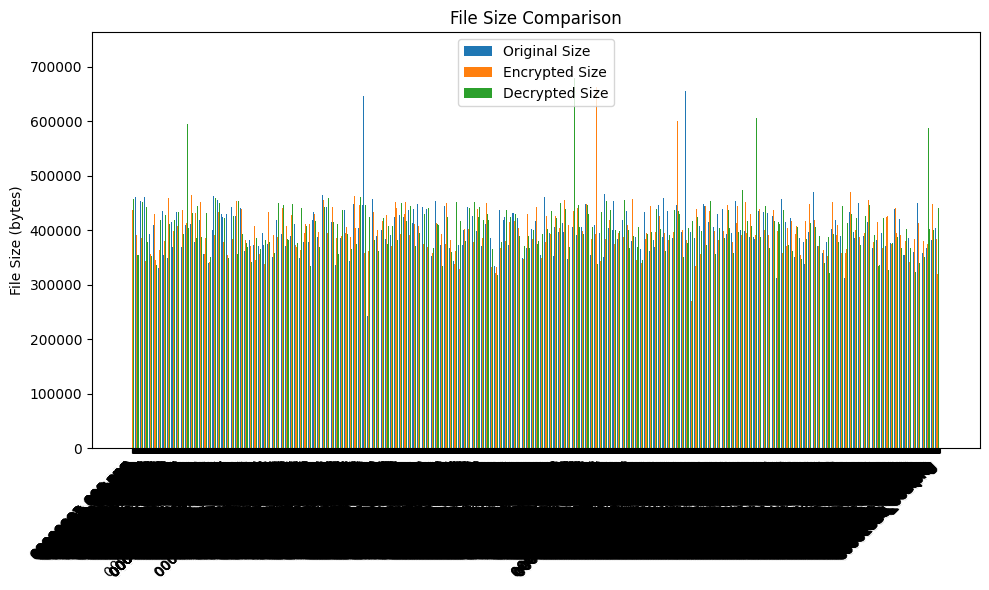

<ipython-input-31-75b62bfc41fe>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=times, ax=ax, palette='viridis')


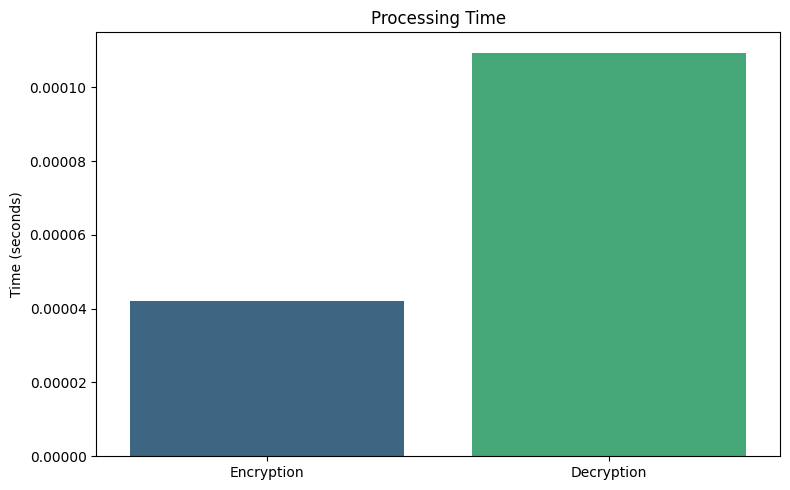

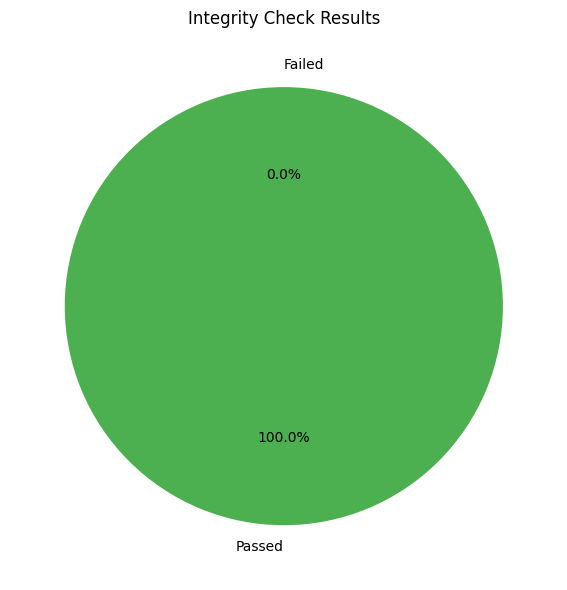

In [ ]:
# Block 8: Charts for Statistics
import matplotlib.pyplot as plt
import seaborn as sns

# File Size Comparison (Bar Chart)
def plot_file_size_statistics():
    fig, ax = plt.subplots(figsize=(10, 6))

    labels = [os.path.basename(f) for f in image_files]
    x = range(len(labels))

    ax.bar(x, original_sizes, width=0.25, label="Original Size", align="center")
    ax.bar([i + 0.25 for i in x], encrypted_sizes, width=0.25, label="Encrypted Size", align="center")
    ax.bar([i + 0.5 for i in x], decrypted_sizes, width=0.25, label="Decrypted Size", align="center")

    ax.set_xticks([i + 0.25 for i in x])
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel("File Size (bytes)")
    ax.set_title("File Size Comparison")
    ax.legend()

    plt.tight_layout()
    plt.show()

# Processing Time (Bar Chart)
def plot_processing_time(encryption_time, decryption_time):
    fig, ax = plt.subplots(figsize=(8, 5))

    times = [encryption_time, decryption_time]
    labels = ['Encryption', 'Decryption']

    sns.barplot(x=labels, y=times, ax=ax, palette='viridis')

    ax.set_ylabel("Time (seconds)")
    ax.set_title("Processing Time")

    plt.tight_layout()
    plt.show()

# Integrity Check (Pie Chart)
def plot_integrity_check(passed, failed):
    fig, ax = plt.subplots(figsize=(6, 6))

    labels = ['Passed', 'Failed']
    sizes = [passed, failed]
    colors = ['#4CAF50', '#FF5733']

    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title("Integrity Check Results")

    plt.tight_layout()
    plt.show()

# Call the functions with the calculated statistics
plot_file_size_statistics()
plot_processing_time(encryption_time, decryption_time)
plot_integrity_check(passed=len(image_files), failed=0)  # Adjust 'failed' if some files fail
